<a href="https://colab.research.google.com/github/sophia-zhang-qwq/animal-pose-est/blob/main/docs/notebooks/sleap_on_2fruitflies_rretracked.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Post-inference tracking

In tracking, we associate the poses (that were detected within individual frames) across time such that they belong to the same individual.

Since we typically do this separately, it is sometimes desirable to tweak the tracking parameters to optimize accuracy without having to re-run inference (e.g., `sleap-track`).

In this notebook, we will explore how to re-run the tracking given an existing predictions SLP file.

**Note:** Tracking does not run on the GPU, so this notebook can be run locally on your computer without the hassle of uploading your data if desired.

## 1. Setup SLEAP

Run this cell first to install SLEAP. If you get a dependency error in subsequent cells, just click **Runtime** → **Restart runtime** to reload the packages.


### Install

In [1]:
# override and install python 3.10
! wget -O mini.sh https://repo.anaconda.com/miniconda/Miniconda3-py310_22.11.1-1-Linux-x86_64.sh
! chmod +x mini.sh
! bash ./mini.sh -b -f -p /usr/local
! conda install -q -y jupyter
! conda install -q -y google-colab -c conda-forge
! python -m ipykernel install --name "py310" --user

--2025-04-20 23:03:48--  https://repo.anaconda.com/miniconda/Miniconda3-py310_22.11.1-1-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.191.158, 104.16.32.241, 2606:4700::6810:20f1, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.191.158|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72402405 (69M) [application/x-sh]
Saving to: ‘mini.sh’

mini.sh             100%[===================>]  69.05M  88.5MB/s    in 0.8s    

2025-04-20 23:03:49 (88.5 MB/s) - ‘mini.sh’ saved [72402405/72402405]

PREFIX=/usr/local
Unpacking payload ...

Installing base environment...





Preparing transaction: - \ | / - \ | / - done
Executing transaction: | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | done
installation finished.
    You currently have a PYTHONPATH environment variable set. This 

In [2]:
# confirm using python 3.10
! python3 --version

Python 3.10.16


In [3]:
# install sleap and dependencies
! pip install sleap[pypi]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 904.1/904.1 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 43.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 70.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.3/90.3 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.6/290.6 kB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 65.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.8/315.8 kB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.1/156.1 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.9/228.9 kB 24.0 MB/s eta 0:0

In [ ]:
# restart runtime so GPU changes take effect
import os
os.kill(os.getpid(), 9)

### Test

In [2]:
#@title SLEAP and system versions: { display-mode: "form" }
!python -c "import sleap; sleap.versions(); sleap.system_summary()"

RuntimeError: module was compiled against NumPy C-API version 0x10 (NumPy 1.23) but the running NumPy has C-API version 0xf. Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem.
2025-04-20 23:11:39.916110: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2025-04-20 23:11:39.916208: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
INFO:matplotlib.font_manager:generated new fontManager
SLEAP: 1.4.1
TensorFlow: 2.8.4
Numpy: 1.22.4
Python: 3.10.16
OS: Linux-6.1.123+-x86_64-with-gl

# 2. Setup data
Here we're downloading an existing `.slp` file with predictions and the corresponding `.mp4` video.

You should replace this with Google Drive mounting if running this on Google Colab, or simply skip it altogether and just set the paths below if running locally.

In [3]:
# 2fruitflies data
!wget -q -O fly_clip.mp4 https://github.com/talmolab/sleap-tutorial-uo/blob/main/data/fly_clip.mp4?raw=true
!wget -q -O predictions.slp https://github.com/talmolab/sleap-tutorial-uo/blob/main/data/predictions.slp?raw=true

In [8]:
PREDICTIONS_FILE = "predictions.slp"

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
import os

# Change to your current Google Drive working directory
os.chdir('/content/drive/MyDrive/sleap/flies13')
!ls

flies13.train.pkg.slp  fly_clip.mp4  script.py


# 3. Track

In [ ]:
"""
# Load predictions
labels = sleap.load_file(PREDICTIONS_FILE)

# Here I'm removing the tracks so we just have instances without any tracking applied.
for instance in labels.instances():
    instance.track = None
labels.tracks = []
labels
"""

In [17]:
!python -c "exec(open('/content/drive/My Drive/sleap/flies13/track_script.py').read())"

RuntimeError: module was compiled against NumPy C-API version 0x10 (NumPy 1.23) but the running NumPy has C-API version 0xf. Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem.
2025-04-20 23:22:19.707779: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2025-04-20 23:22:19.707835: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/usr/local/lib/python3.10/site-packages/networkx/readwrite/json_graph/node_link.py:287: FutureWarning: 
The default value will be changed to `edges="

Here we create a tracker with the options we want to experiment with. You can [read more about tracking in the documentation](https://sleap.ai/guides/proofreading.html#tracking-methods) or the parameters in the [`sleap-track` CLI help](https://sleap.ai/guides/cli.html#sleap-track).

In [ ]:
# Create tracker
tracker = sleap.nn.tracking.Tracker.make_tracker_by_name(
    # General tracking options
    tracker="flow",
    track_window=3,

    # Matching options
    similarity="instance",
    match="greedy",
    min_new_track_points=1,
    min_match_points=1,

    # Optical flow options (only applies to "flow" tracker)
    img_scale=0.5,
    of_window_size=21,
    of_max_levels=3,

    # Pre-tracking filtering options
    target_instance_count=2,
    pre_cull_to_target=True,
    pre_cull_iou_threshold=0.8,

    # Post-tracking filtering options
    post_connect_single_breaks=True,
    clean_instance_count=0,
    clean_iou_threshold=None,
)

Next we'll actually run the tracking on each frame. This might take a bit longer when using the `"flow"` method.

In [ ]:
tracked_lfs = []
for lf in labels:
    lf.instances = tracker.track(lf.instances, img=lf.image, img_hw=lf.image.shape[:2])
    tracked_lfs.append(lf)
tracked_labels = sleap.Labels(tracked_lfs)
tracked_labels

Labels(labeled_frames=1350, videos=1, skeletons=1, tracks=2)

In [20]:
!python -c "exec(open('/content/drive/My Drive/sleap/flies13/track_script.py').read())"
# tracked_labels.save("retracked.slp")

RuntimeError: module was compiled against NumPy C-API version 0x10 (NumPy 1.23) but the running NumPy has C-API version 0xf. Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem.
2025-04-20 23:31:18.953945: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2025-04-20 23:31:18.953999: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/usr/local/lib/python3.10/site-packages/networkx/readwrite/json_graph/node_link.py:287: FutureWarning: 
The default value will be changed to `edges="

# 4. Inspect and save

Let's see the results and save out the tracked predictions.

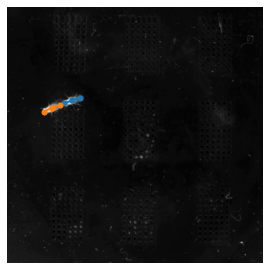

In [ ]:
#tracked_labels[0].plot(scale=0.25)

RuntimeError: module was compiled against NumPy C-API version 0x10 (NumPy 1.23) but the running NumPy has C-API version 0xf. Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem.
2025-04-21 00:19:13.028518: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2025-04-21 00:19:13.028633: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/usr/local/lib/python3.10/site-packages/networkx/readwrite/json_graph/node_link.py:287: FutureWarning: 
The default value will be changed to `edges="

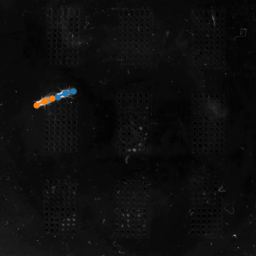

In [21]:
!python -c "import sleap; import matplotlib.pyplot as plt; retracked=sleap.load_file('retracked.slp'); retracked[0].plot(scale=0.25); plt.savefig('retracked_0.png')"

from IPython.display import Image
Image('retracked_0.png')

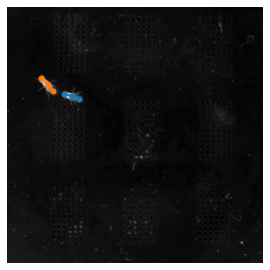

In [ ]:
#tracked_labels[100].plot(scale=0.25)

RuntimeError: module was compiled against NumPy C-API version 0x10 (NumPy 1.23) but the running NumPy has C-API version 0xf. Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem.
2025-04-21 00:20:00.277104: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2025-04-21 00:20:00.277157: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/usr/local/lib/python3.10/site-packages/networkx/readwrite/json_graph/node_link.py:287: FutureWarning: 
The default value will be changed to `edges="

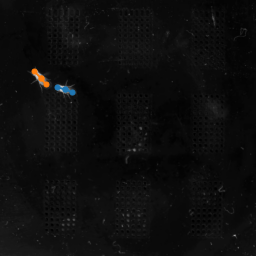

In [22]:
!python -c "import sleap; import matplotlib.pyplot as plt; retracked=sleap.load_file('retracked.slp'); retracked[100].plot(scale=0.25); plt.savefig('retracked_100.png')"

Image('retracked_100.png')

In [ ]:
tracked_labels.save("retracked.slp")